In [13]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
BASE_DIR = 'Fall2025/AML/Project/data'

# --- Load all weekly input files ---
print("Loading input files...")
input_files = glob.glob(os.path.join(BASE_DIR, 'train/input_*.csv'))
input_df = pd.concat([pd.read_csv(f) for f in input_files[:2]], ignore_index=True)
print(f"Loaded {len(input_files)} input files.")

Loading input files...
Loaded 18 input files.


In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
input_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023120700,82,False,44962,1,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,48.93,25.74,1.80,0.11,18.15,250.73,9,35.009998,8.84
1,2023120700,82,False,44962,2,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.00,25.91,1.79,0.40,21.66,248.18,9,35.009998,8.84
2,2023120700,82,False,44962,3,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.08,26.07,1.75,0.72,25.77,248.80,9,35.009998,8.84
3,2023120700,82,False,44962,4,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.16,26.22,1.72,0.89,29.81,247.48,9,35.009998,8.84
4,2023120700,82,False,44962,5,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.25,26.37,1.68,1.03,34.20,245.87,9,35.009998,8.84


In [16]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565686 entries, 0 to 565685
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   565686 non-null  int64  
 1   play_id                   565686 non-null  int64  
 2   player_to_predict         565686 non-null  bool   
 3   nfl_id                    565686 non-null  int64  
 4   frame_id                  565686 non-null  int64  
 5   play_direction            565686 non-null  object 
 6   absolute_yardline_number  565686 non-null  int64  
 7   player_name               565686 non-null  object 
 8   player_height             565686 non-null  object 
 9   player_weight             565686 non-null  int64  
 10  player_birth_date         565686 non-null  object 
 11  player_position           565686 non-null  object 
 12  player_side               565686 non-null  object 
 13  player_role               565686 non-null  o

In [17]:
print("\nLoading output files...")
output_files = glob.glob(os.path.join(BASE_DIR, 'train/output_*.csv'))
output_df = pd.concat([pd.read_csv(f) for f in output_files], ignore_index=True)
print(f"Loaded {len(output_files)} output files.")


Loading output files...
Loaded 18 output files.


In [18]:
output_df.head()

,game_id,play_id,nfl_id,frame_id,x,y
0,2023102600,109,54650,1,70.87,35.44
1,2023102600,109,54650,2,70.45,35.58
2,2023102600,109,54650,3,70.05,35.74
3,2023102600,109,54650,4,69.66,35.92
4,2023102600,109,54650,5,69.28,36.11


In [19]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562936 entries, 0 to 562935
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   game_id   562936 non-null  int64  
 1   play_id   562936 non-null  int64  
 2   nfl_id    562936 non-null  int64  
 3   frame_id  562936 non-null  int64  
 4   x         562936 non-null  float64
 5   y         562936 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 25.8 MB


In [33]:
def feature_engineering(df):
    df['player_birth_date'] = pd.to_datetime(df['player_birth_date'])
    # Example feature engineering steps
    df['age_at_game'] = df.apply(
        lambda row: (
            pd.to_datetime(str(row['game_id'])[:-2], format='%Y%m%d') -
            row['player_birth_date']
        ).days // 365,
        axis=1
    )
    df['velocity_x'] = df['s'] * np.cos(np.radians(df['dir']))
    df['velocity_y'] = df['s'] * np.sin(np.radians(df['dir']))

    df['a_x'] = df['a'] * np.cos(np.radians(df['dir']))
    df['a_y'] = df['a'] * np.sin(np.radians(df['dir']))

    df['dist_to_ball'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + 
        (df['y'] - df['ball_land_y'])**2
    )
    
    df['angle_to_ball'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )
    
    df['velocity_toward_ball'] = (
        df['velocity_x'] * np.cos(df['angle_to_ball']) + 
        df['velocity_y'] * np.sin(df['angle_to_ball'])
    )

    df['time_to_ball'] = df['num_frames_output'] / 10.0
    df['orientation_diff'] = np.abs(df['o'] - df['dir'])
    df['orientation_diff'] = np.minimum(df['orientation_diff'], 360 - df['orientation_diff'])
    
    df['role_targeted_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(int)
    df['role_defensive_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(int)
    df['role_passer'] = (df['player_role'] == 'Passer').astype(int)
    df['side_offense'] = (df['player_side'] == 'Offense').astype(int)
    df['player_height_inches'] = df['player_height'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]) if pd.notnull(x) else np.nan)
    df['bmi'] = (df['player_weight'] / (df['player_height_inches']**2)) * 703
    df['momentum_x'] = df['player_weight'] * df['velocity_x']
    df['momentum_y'] = df['player_weight'] * df['velocity_y']
    return df

In [34]:
feature_engineering(input_df).head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,age_at_game,velocity_x,velocity_y,dist_to_ball,angle_to_ball,velocity_toward_ball,time_to_ball,orientation_diff,role_targeted_receiver,role_defensive_coverage,role_passer,side_offense,player_height_inches,bmi,momentum_x,momentum_y,a_x,y_y,a_y
0,2023120700,82,False,44962,1,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,48.93,25.74,1.80,0.11,18.15,250.73,9,35.009998,8.84,30,1.710440,0.560710,21.894667,-2.259804,-1.520248,0.9,127.42,0,1,0,0,71,26.496727,324.983535,106.534981,0.104527,0.034266,0.034266
1,2023120700,82,False,44962,2,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.00,25.91,1.79,0.40,21.66,248.18,9,35.009998,8.84,30,1.663609,0.660685,22.070456,-2.257355,-1.565522,0.9,133.48,0,1,0,0,71,26.496727,316.085701,125.530233,0.371756,0.147639,0.147639
2,2023120700,82,False,44962,3,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.08,26.07,1.75,0.72,25.77,248.80,9,35.009998,8.84,30,1.575956,0.760829,22.244951,-2.255577,-1.586104,0.9,136.97,0,1,0,0,71,26.496727,299.431723,144.557578,0.648394,0.313027,0.313027
3,2023120700,82,False,44962,4,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.16,26.22,1.72,0.89,29.81,247.48,9,35.009998,8.84,30,1.492407,0.855056,22.411759,-2.254109,-1.605337,0.9,142.33,0,1,0,0,71,26.496727,283.557400,162.460583,0.772234,0.442442,0.442442
4,2023120700,82,False,44962,5,right,35,Damontae Kazee,5-11,190,1993-06-05,FS,Defense,Defensive Coverage,49.25,26.37,1.68,1.03,34.20,245.87,9,35.009998,8.84,30,1.389495,0.944300,22.584918,-2.253006,-1.609038,0.9,148.33,0,1,0,0,71,26.496727,264.004119,179.417014,0.851893,0.578946,0.578946


In [35]:
# input_df['nfl_id'].value_counts()

In [36]:
continuous_cols = ['player_weight', 'player_height_inches', 'bmi', 'a_x', 'a_y', 'o', 'velocity_x', 'velocity_y', 'dist_to_ball', 'momentum_x', 'momentum_y']
categorical_cols = ['player_position', 'player_role', 'player_side']
input_df.shape


(565686, 42)

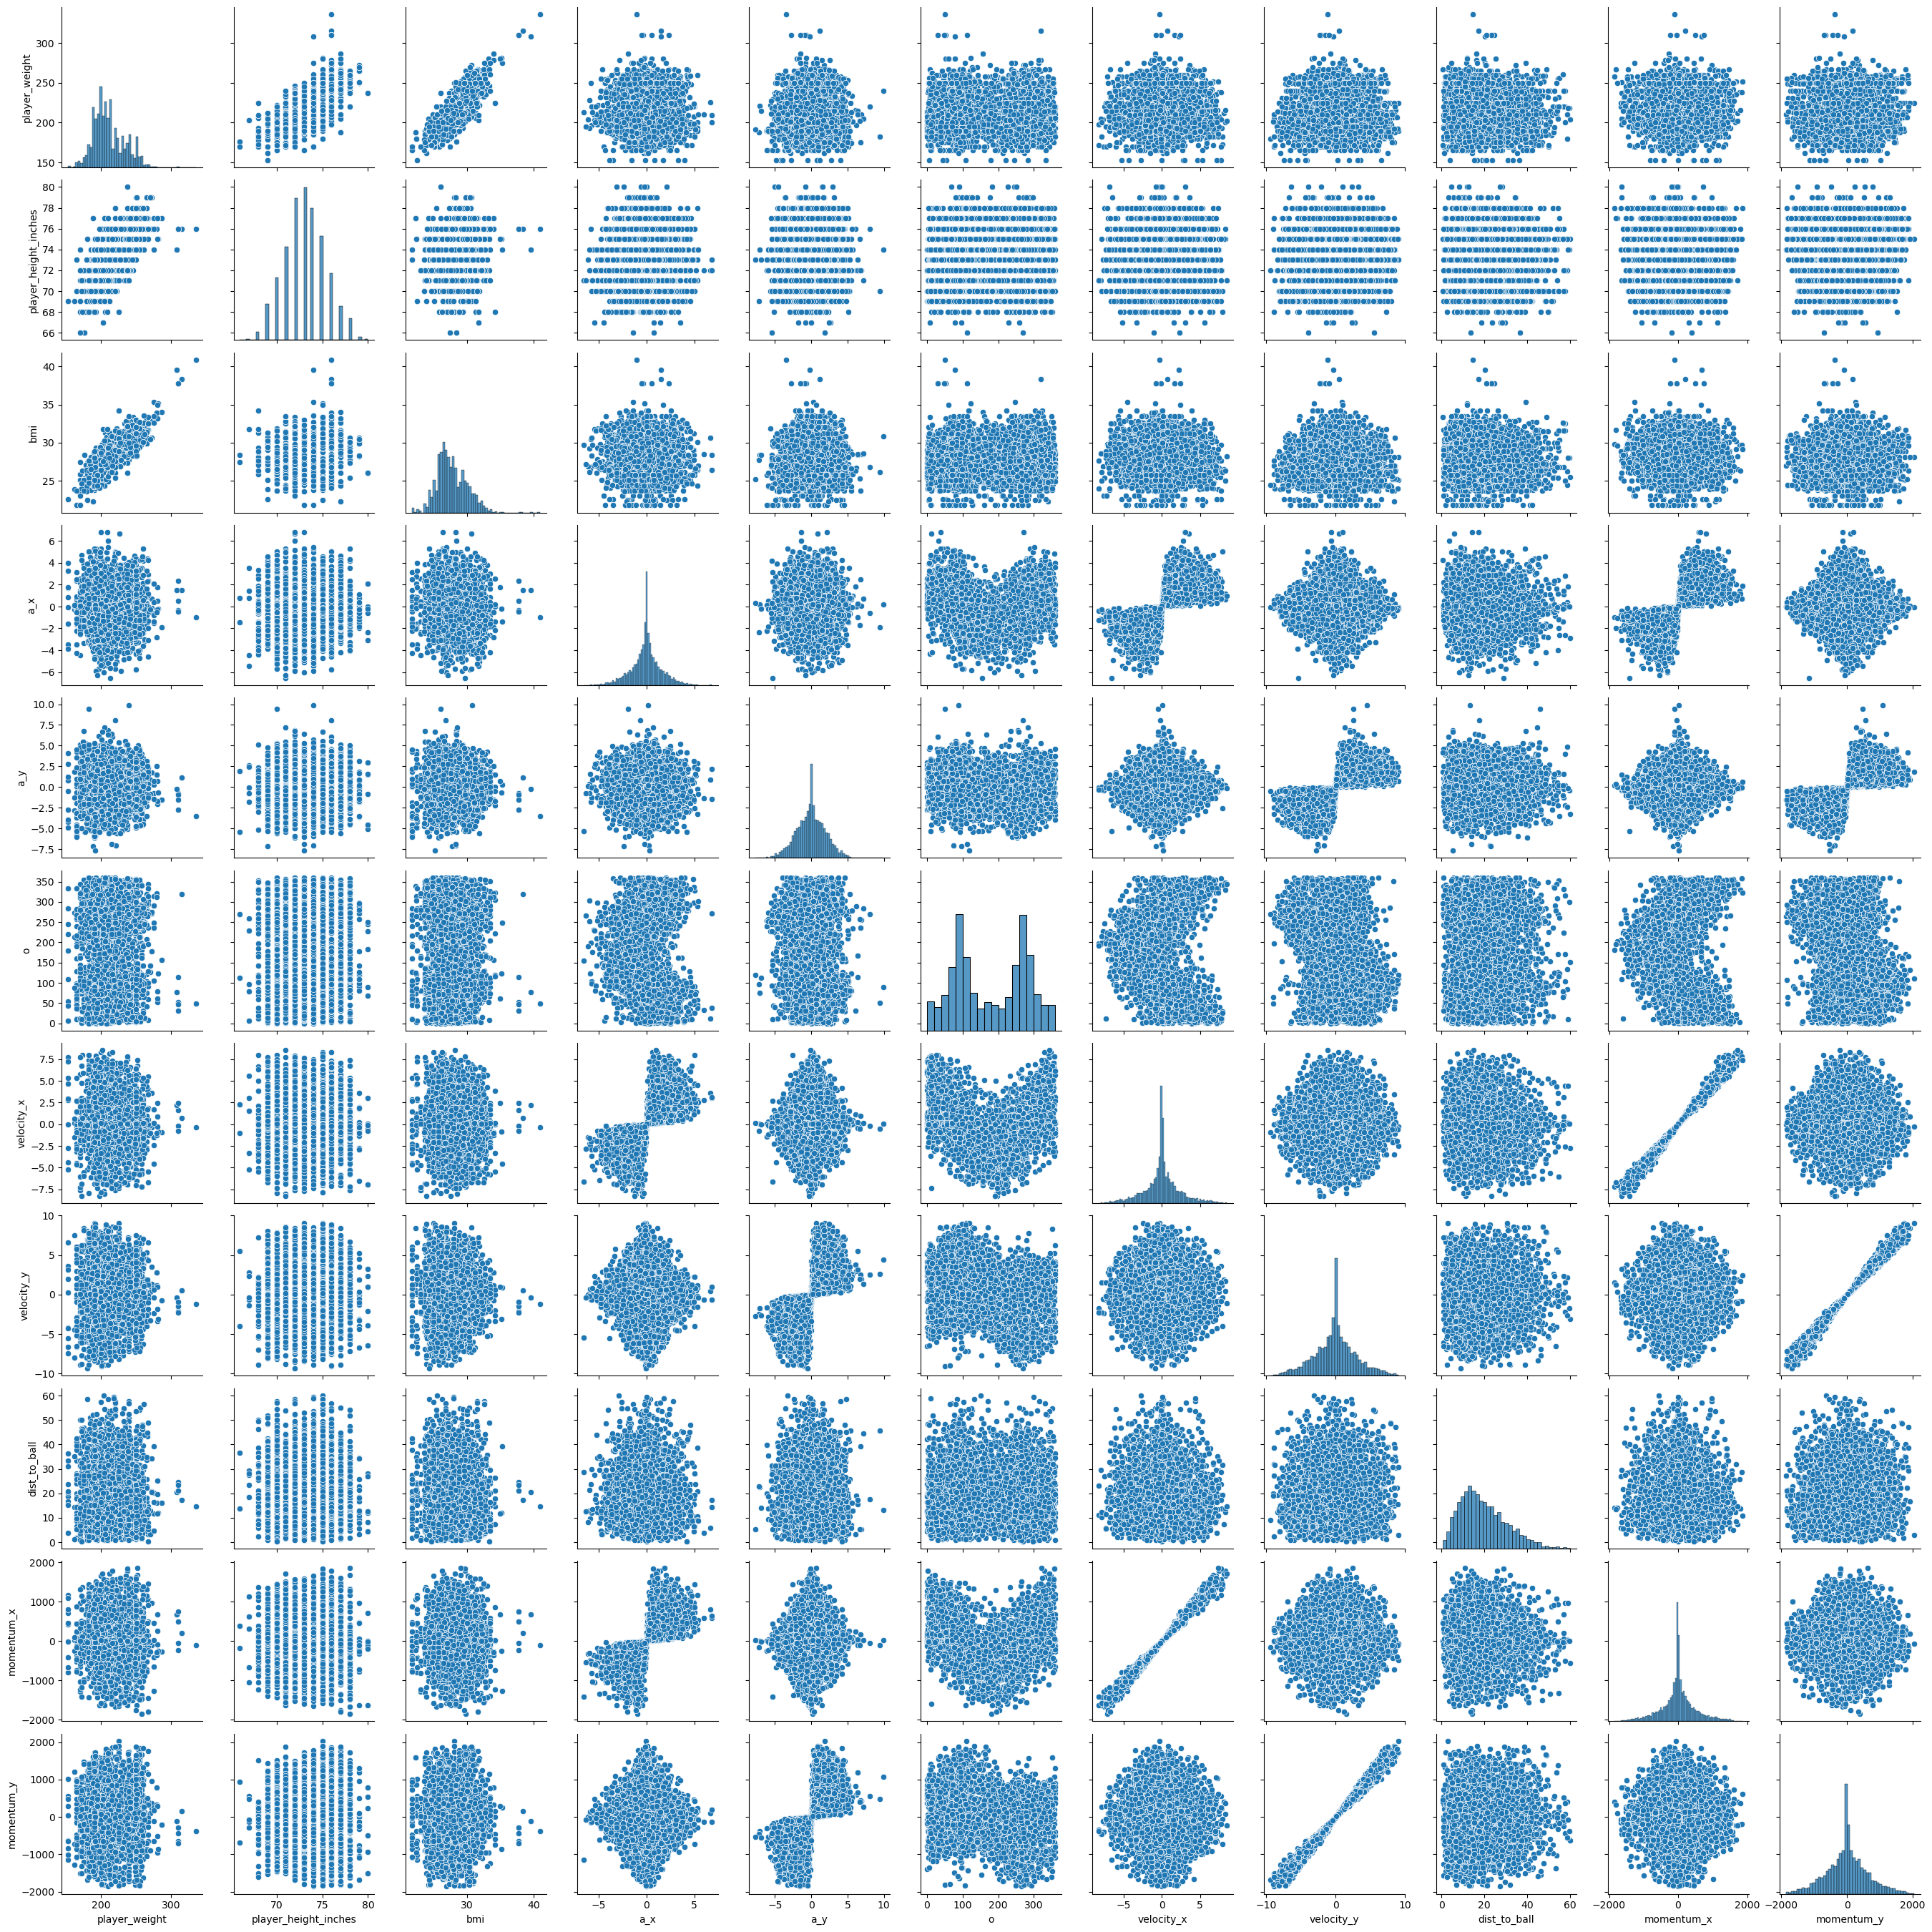

In [40]:
sns.pairplot(input_df[continuous_cols].dropna().sample(5000))
plt.show()